Vítejte u druhého projektu do SUI.
V rámci projektu Vás čeká několik cvičení, v nichž budete doplňovat poměrně malé fragmenty kódu (místo je vyznačeno pomocí `None` nebo `pass`).
Pokud se v buňce s kódem již něco nachází, využijte/neničte to.
Buňky nerušte ani nepřidávejte.

Až budete s řešením hotovi, vyexportujte ho ("Download as") jako PDF i pythonovský skript a ty odevzdejte pojmenované názvem týmu (tj. loginem vedoucího).
Dbejte, aby bylo v PDF všechno vidět (nezůstal kód za okrajem stránky apod.).

U všech cvičení je uveden orientační počet řádků řešení.
Berte ho prosím opravdu jako orientační, pozornost mu věnujte, pouze pokud ho významně překračujete.

In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import scipy.stats

# Přípravné práce
Prvním úkolem v tomto projektu je načíst data, s nimiž budete pracovat.
Vybudujte jednoduchou třídu, která se umí zkonstruovat z cesty k negativním a pozitivním příkladům, a bude poskytovat:
- pozitivní a negativní příklady (`dataset.pos`, `dataset.neg` o rozměrech [N, 7])
- všechny příklady a odpovídající třídy (`dataset.xs` o rozměru [N, 7], `dataset.targets` o rozměru [N])

K načítání dat doporučujeme využít `np.loadtxt()`.
Netrapte se se zapouzdřováním a gettery, berte třídu jako Plain Old Data.

Načtěte trénovací (`{positives,negatives}.trn`), validační (`{positives,negatives}.val`) a testovací (`{positives,negatives}.tst`) dataset, pojmenujte je po řadě `train_dataset`, `val_dataset` a `test_dataset`. 

**(6 řádků)** 


In [2]:
class BinaryDataset:
    def __init__(self, positives_path, negatives_path) -> None:
        self.pos = np.loadtxt(positives_path)
        self.neg = np.loadtxt(negatives_path)
        self.xs = np.concatenate((self.pos, self.neg))
        self.targets = np.concatenate((np.ones(self.pos.shape[0]), np.zeros(self.neg.shape[0])))       

train_dataset = BinaryDataset('positives.trn', 'negatives.trn')
val_dataset = BinaryDataset('positives.val', 'negatives.val')
test_dataset = BinaryDataset('positives.tst', 'negatives.tst')

print('positives', train_dataset.pos.shape)
print('negatives', train_dataset.neg.shape)
print('xs', train_dataset.xs.shape)
print('targets', train_dataset.targets.shape)

positives (2280, 7)
negatives (6841, 7)
xs (9121, 7)
targets (9121,)


V řadě následujících cvičení budete pracovat s jedním konkrétním příznakem. Naimplementujte proto funkci, která vykreslí histogram rozložení pozitivních a negativních příkladů z jedné sady. Nezapomeňte na legendu, ať je v grafu jasné, které jsou které. Funkci zavoláte dvakrát, vykreslete histogram příznaku `5` -- tzn. šestého ze sedmi -- pro trénovací a validační data

**(5 řádků)**

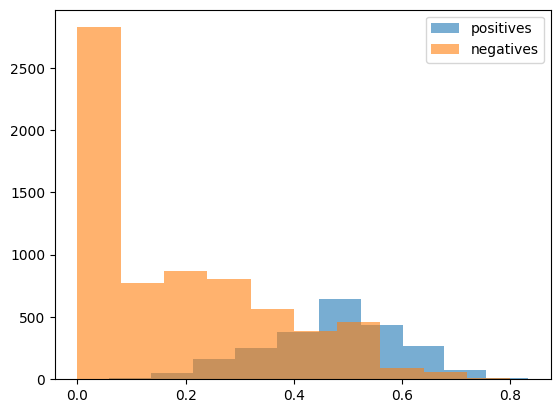

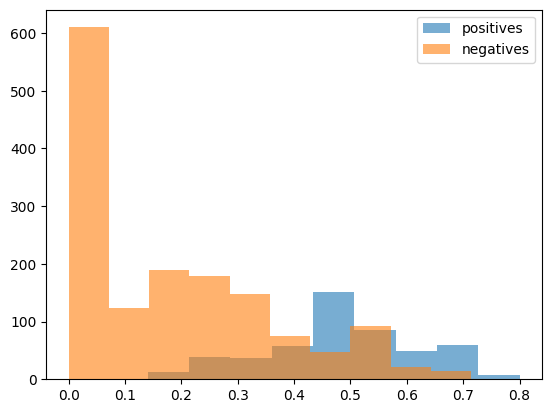

In [3]:
FOI = 5  # Feature Of Interest

def plot_data(poss, negs):
    plt.figure()
    plt.hist(poss, alpha=0.6, label="positives")
    plt.hist(negs, alpha=0.6, label="negatives")
    plt.legend()

plot_data(train_dataset.pos[:, FOI], train_dataset.neg[:, FOI])
plot_data(val_dataset.pos[:, FOI], val_dataset.neg[:, FOI])

### Evaluace klasifikátorů
Než přistoupíte k tvorbě jednotlivých klasifikátorů, vytvořte funkci pro jejich vyhodnocování.
Nechť se jmenuje `evaluate` a přijímá po řadě klasifikátor, pole dat (o rozměrech [N, F]) a pole tříd ([N]).
Jejím výstupem bude _přesnost_ (accuracy), tzn. podíl správně klasifikovaných příkladů.

Předpokládejte, že klasifikátor poskytuje metodu `.prob_class_1(data)`, která vrací pole posteriorních pravděpodobností třídy 1 pro daná data.
Evaluační funkce bude muset provést tvrdé prahování (na hodnotě 0.5) těchto pravděpodobností a srovnání získaných rozhodnutí s referenčními třídami.
Využijte fakt, že `numpy`ovská pole lze mj. porovnávat se skalárem.

**(3 řádky)**

In [4]:
def evaluate(classifier, inputs, targets):
    posteri_probs = classifier.prob_class_1(inputs)
    match_count = np.count_nonzero((posteri_probs >= 0.5) == targets)
    return match_count / targets.size

class Dummy:
    def prob_class_1(self, xs):
        return np.asarray([0.2, 0.7, 0.7])

print(evaluate(Dummy(), None, np.asarray([0, 0, 1])))  # should be 0.66

0.6666666666666666


### Baseline
Vytvořte klasifikátor, který ignoruje vstupní data.
Jenom v konstruktoru dostane třídu, kterou má dávat jako tip pro libovolný vstup.
Nezapomeňte, že jeho metoda `.prob_class_1(data)` musí vracet pole správné velikosti.

**(4 řádky)**

In [5]:
class PriorClassifier:
    def __init__(self, clas) -> None:
        self._clas = clas 
    def prob_class_1(self, data):
        return np.full(data.shape[0], self._clas)

baseline = PriorClassifier(0)
val_acc = evaluate(baseline, val_dataset.xs[:, FOI], val_dataset.targets)
print('Baseline val acc:', val_acc)

Baseline val acc: 0.75


# Generativní klasifikátory
V této  části vytvoříte dva generativní klasifikátory, oba založené na Gaussovu rozložení pravděpodobnosti.

Začněte implementací funce, která pro daná 1-D data vrátí Maximum Likelihood odhad střední hodnoty a směrodatné odchylky Gaussova rozložení, které data modeluje.
Funkci využijte pro natrénovaní dvou modelů: pozitivních a negativních příkladů.
Získané parametry -- tzn. střední hodnoty a směrodatné odchylky -- vypíšete.

**(1 řádek)**

In [6]:
def mle_gauss_1d(data):
    return (np.mean(data), np.std(data))

mu_pos, std_pos = mle_gauss_1d(train_dataset.pos[:, FOI])
mu_neg, std_neg = mle_gauss_1d(train_dataset.neg[:, FOI])

print('Pos mean: {:.2f} std: {:.2f}'.format(mu_pos, std_pos))
print('Neg mean: {:.2f} std: {:.2f}'.format(mu_neg, std_neg))

Pos mean: 0.48 std: 0.13
Neg mean: 0.17 std: 0.18


Ze získaných parametrů vytvořte `scipy`ovská gaussovská rozložení `scipy.stats.norm`.
S využitím jejich metody `.pdf()` vytvořte graf, v němž srovnáte skutečné a modelové rozložení pozitivních a negativních příkladů.
Rozsah x-ové osy volte od -0.5 do 1.5 (využijte `np.linspace`) a u volání `plt.hist()` nezapomeňte nastavit `density=True`, aby byl histogram normalizovaný a dal se srovnávat s modelem.

**(2 + 8 řádků)**

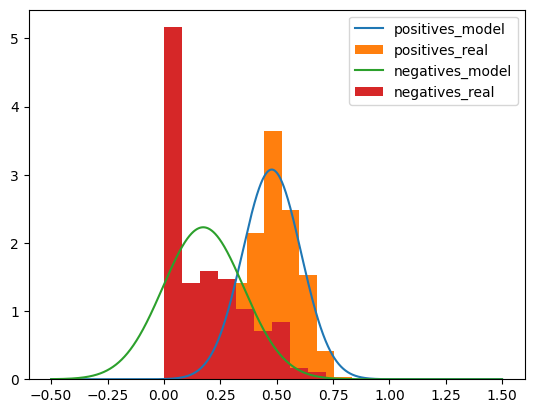

In [7]:
x_pos = np.linspace(-0.5, 1.5, train_dataset.pos.shape[0])
gauss_pos = scipy.stats.norm(mu_pos, std_pos)

plt.figure()
plt.plot(x_pos, gauss_pos.pdf(x_pos), label="positives_model")
plt.hist(train_dataset.pos[:, FOI], density=True, label="positives_real")

x_neg = np.linspace(-0.5, 1.5, train_dataset.neg.shape[0])
gauss_neg = scipy.stats.norm(mu_neg, std_neg)

plt.plot(x_neg, gauss_neg.pdf(x_neg), label="negatives_model")
plt.hist(train_dataset.neg[:, FOI], density=True, label="negatives_real")
plt.legend()


Naimplementujte binární generativní klasifikátor. 
Při konstrukci přijímá dvě rozložení poskytující metodu `.pdf()` a odpovídající apriorní pravděpodobnost tříd.
Dbejte, aby Vám uživatel nemohl zadat neplatné apriorní pravděpodobnosti.
Jako všechny klasifikátory v tomto projektu poskytuje metodu `prob_class_1()`.

**(9 řádků)**

In [8]:
class GenerativeClassifier2Class:
    def __init__(self, apriori_0, distribution_0, distribution_1) -> None:
        if (apriori_0 < 0 or apriori_0 > 1):
            raise ValueError("Given apriori probability is not in valid range")
        self._dist_0 = distribution_0
        self._apr_0 = apriori_0
        self._dist_1 = distribution_1
        self._apr_1 = 1 - apriori_0
 
    def prob_class_1(self, data):
        return (self._dist_1.pdf(data) * self._apr_1) / (self._dist_1.pdf(data) * self._apr_1 + self._dist_0.pdf(data) * self._apr_0) 

Nainstancujte dva generativní klasifikátory: jeden s rovnoměrnými priory a jeden s apriorní pravděpodobností 0.75 pro třídu 0 (negativní příklady).
Pomocí funkce `evaluate()` vyhodnotíte jejich úspěšnost na validačních datech.

**(2 řádky)**

In [9]:
classifier_flat_prior = GenerativeClassifier2Class(0.5, gauss_neg, gauss_pos)
classifier_full_prior = GenerativeClassifier2Class(0.75, gauss_neg, gauss_pos)
print('flat:', evaluate(classifier_flat_prior, val_dataset.xs[:, FOI], val_dataset.targets))
print('full:', evaluate(classifier_full_prior, val_dataset.xs[:, FOI], val_dataset.targets))

flat: 0.809
full: 0.8475


Vykreslete průběh posteriorní pravděpodobnosti třídy 1 jako funkci příznaku 5, opět v rozsahu <-0.5; 1.5> pro oba klasifikátory.
Do grafu zakreslete i histogramy rozložení trénovacích dat, opět s `density=True` pro zachování dynamického rozsahu.

**(8 řádků)**

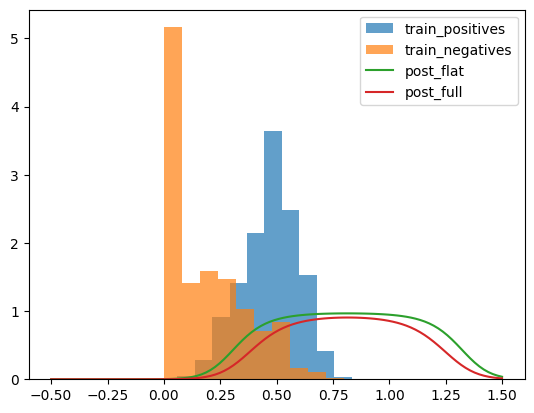

In [10]:
x = np.linspace(-0.5, 1.5, 100)
y_flat = classifier_flat_prior.prob_class_1(x)
y_full = classifier_full_prior.prob_class_1(x)

plt.hist(train_dataset.pos[:, FOI], alpha=0.7, density=True, label="train_positives")
plt.hist(train_dataset.neg[:, FOI], alpha=0.7, density=True, label="train_negatives")
plt.plot(x, y_flat, label="post_flat")
plt.plot(x, y_full, label="post_full")
plt.legend()


# Diskriminativní klasifikátory
V následující části budete pomocí (lineární) logistické regrese přímo modelovat posteriorní pravděpodobnost třídy 1.
Modely budou založeny čistě na NumPy, takže nemusíte instalovat nic dalšího.
Nabitějších toolkitů se dočkáte ve třetím projektu.

In [11]:
def logistic_sigmoid(x):
    return np.exp(-np.logaddexp(0, -x))

def binary_cross_entropy(probs, targets):
    return np.sum(-targets * np.log(probs) - (1-targets)*np.log(1-probs)) 

class LogisticRegressionNumpy:
    def __init__(self, dim):
        self.w = np.array([0.0] * dim)
        self.b = np.array([0.0])
        
    def prob_class_1(self, x):
        return logistic_sigmoid(x @ self.w + self.b)

Diskriminativní klasifikátor očekává, že dostane vstup ve tvaru `[N, F]`.
Pro práci na jediném příznaku bude tedy zapotřebí vyřezávat příslušná data v správném formátu (`[N, 1]`). 
Doimplementujte třídu `FeatureCutter` tak, aby to zařizovalo volání její instance.
Který příznak se použije, nechť je konfigurováno při konstrukci.

Může se Vám hodit `np.newaxis`.

**(2 řádky)**

In [12]:
class FeatureCutter:
    def __init__(self, fea_id):
        self._fea_id = fea_id
        
    def __call__(self, x):
        return x[:, self._fea_id, np.newaxis]


Dalším krokem je implementovat funkci, která model vytvoří a natrénuje.
Jejím výstupem bude (1) natrénovaný model, (2) průběh trénovací loss a (3) průběh validační přesnosti.
Neuvažujte žádné minibatche, aktualizujte váhy vždy na celém trénovacím datasetu.
Po každém kroku vyhodnoťte model na validačních datech.
Jako model vracejte ten, který dosáhne nejlepší validační přesnosti.
Jako loss použijte binární cross-entropii  a logujte průměr na vzorek.
Pro výpočet validační přesnosti využijte funkci `evaluate()`.
Oba průběhy vracejte jako obyčejné seznamy.

Doporučujeme dělit efektivní learning rate počtem vzorků, na nichž je počítana loss.

**(cca 11 řádků)**

In [13]:
def train_logistic_regression(nb_epochs, lr, in_dim, fea_preprocessor):
    model = LogisticRegressionNumpy(in_dim)
    best_model = copy.deepcopy(model)
    losses = []
    accuracies = []
    
    train_X = fea_preprocessor(train_dataset.xs)
    train_t = train_dataset.targets
    
    lr = lr / train_X.shape[0]
    val_X = fea_preprocessor(val_dataset.xs)
    for i in range(nb_epochs):
        probs = model.prob_class_1(train_X)
        gradient = (probs - train_t) @ (train_X)
        model.w = model.w - lr * gradient
        model.b = model.b - lr * np.sum(probs - train_t)
        cross_entropy_avg = binary_cross_entropy(probs, train_t) / train_X.shape[0]
        losses.append(cross_entropy_avg)
        accuracy = evaluate(model, val_X, val_dataset.targets)
        accuracies.append(accuracy)
        if accuracy >= np.max(accuracies):
            best_model = copy.deepcopy(model)
        
    return best_model, losses, accuracies

Funkci zavolejte a natrénujte model.
Uveďte zde parametry, které vám dají slušný výsledek.
Měli byste dostat přesnost srovnatelnou s generativním klasifikátorem s nastavenými priory.
Neměli byste potřebovat víc, než 100 epoch.
Vykreslete průběh trénovací loss a validační přesnosti, osu x značte v epochách.

V druhém grafu vykreslete histogramy trénovacích dat a pravděpodobnost třídy 1 pro x od -0.5 do 1.5, podobně jako výše u generativních klasifikátorů.

**(1 + 5 + 8 řádků)**

w 6.587638568618085 b -3.154149374633294
disc_fea5: 0.84


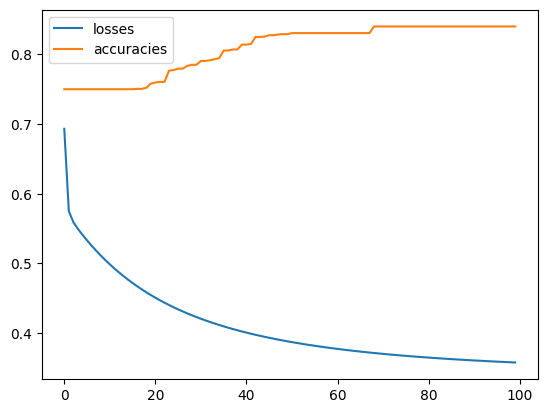

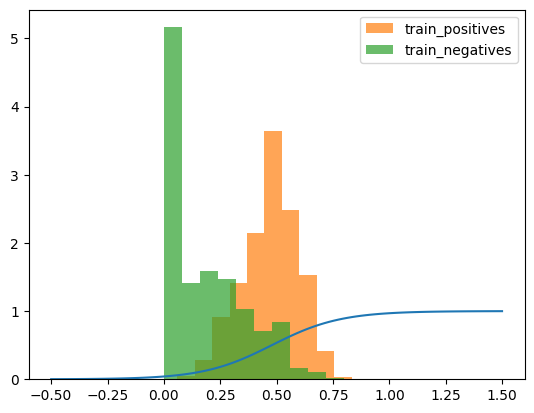

In [14]:
disc_fea5, losses, accuracies = train_logistic_regression(100, 3, 1, FeatureCutter(FOI))

plt.figure()
x_vals = np.arange(100)
plt.plot(x_vals, losses, label="losses")
plt.plot(x_vals, accuracies, label="accuracies")
plt.legend()
print('w', disc_fea5.w.item(), 'b', disc_fea5.b.item())

plt.figure()
x_vals = np.linspace(-0.5, 1.5, 100)
y_vals = disc_fea5.prob_class_1(x_vals[:, np.newaxis])
plt.plot(x_vals, y_vals)
plt.hist(train_dataset.pos[:, FOI], alpha=0.7, density=True, label="train_positives")
plt.hist(train_dataset.neg[:, FOI], alpha=0.7, density=True, label="train_negatives")
plt.legend()
print('disc_fea5:', evaluate(disc_fea5, val_dataset.xs[:, FOI][:, np.newaxis], val_dataset.targets))

## Všechny vstupní příznaky
V posledním cvičení natrénujete logistickou regresi, která využije všechn sedm vstupních příznaků.
Zavolejte funkci z předchozího cvičení, opět vykreslete průběh trénovací loss a validační přesnosti.
Měli byste se dostat nad 90 % přesnosti.

Může se Vám hodit `lambda` funkce.

**(1 + 5 řádků)**

příznaky
V posledním cvičení natrénujete logistickou regresi, která využije všechn sedm vstupních příznaků.
Zavolejte funkci z předchozího cvičení, opět vykreslete průběh trénovací loss a validační přesnosti.
Měli byste se dostat nad 90 % přesnosti.

Může se Vám hodit `lambda` funkce.

**(1 + 5 řádků)**

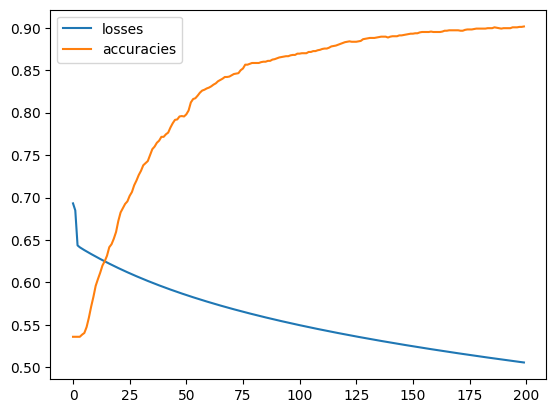

In [15]:
disc_full_fea, losses, accuracies = train_logistic_regression(200, 0.003, 7, lambda x: x)

plt.figure()
x_vals = range(200)
plt.plot(x_vals, losses, label="losses")
plt.plot(x_vals, accuracies, label="accuracies")
plt.legend()

# Závěrem
Konečně vyhodnoťte všech pět vytvořených klasifikátorů na testovacích datech.
Stačí doplnit jejich názvy a předat jim odpovídající příznaky.
Nezapomeňte, že u logistické regrese musíte zopakovat formátovací krok z `FeatureCutter`u.

In [16]:
xs_full = test_dataset.xs
xs_foi = test_dataset.xs[:, FOI]
targets = test_dataset.targets

print('Baseline:', evaluate(baseline, xs_full, targets))
print('Generative classifier (w/o prior):', evaluate(classifier_flat_prior, xs_foi, targets))
print('Generative classifier (correct):', evaluate(classifier_full_prior, xs_foi, targets))
print('Logistic regression:', evaluate(disc_fea5, xs_foi[:, np.newaxis], targets))
print('logistic regression all features:', evaluate(disc_full_fea, xs_full, targets))

Baseline: 0.75
Generative classifier (w/o prior): 0.8
Generative classifier (correct): 0.847
Logistic regression: 0.8505
logistic regression all features: 0.9005


Blahopřejeme ke zvládnutí projektu! Nezapomeňte spustit celý notebook načisto (Kernel -> Restart & Run all) a zkontrolovat, že všechny výpočty prošly podle očekávání.

Mimochodem, vstupní data nejsou synteticky generovaná.
Nasbírali jsme je z baseline řešení předloňského projektu; vaše klasifikátory v tomto projektu predikují, že daný hráč vyhraje dicewars, takže by se daly použít jako heuristika pro ohodnocování listových uzlů ve stavovém prostoru hry.
Pro představu, data jsou z pozic pět kol před koncem partie pro daného hráče.
Poskytnuté příznaky popisují globální charakteristiky stavu hry jako je například poměr délky hranic předmětného hráče k ostatním hranicím.
Nejeden projekt v ročníku 2020 realizoval požadované "strojové učení" kopií domácí úlohy.